In [1]:
__author__ = 'Ragadeepika Pucha <u6051248@utah.edu>, Stephanie Juneau <stephanie.juneau@noirlab.edu>'
__version__ = '20231129' 
__datasets__ = ['desi_edr']  
__keywords__ = ['sparcl', 'spectra', 'database']

# Introduction to DESI Early Data Release (EDR) at the Astro Data Lab with Python 3 Kernel

*Ragadeepika Pucha (U.Utah), Stéphanie Juneau (NOIRLab), Alice Jacques (NOIRLab), Benjamin Weaver (NOIRLab), and the Data Lab Team, with contributions from Anthony Kremin (LBL), Stephen Bailey (LBL) and the DESI Collaboration*

### Table of Contents

* [Goals & Summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports](#import)
* [DESI EDR Database](#desi_edr)
* [Accessing DESI Targets](#desi_target_access)
    * [Selecting Sources based on Targeting Information](#target_info)
    * [Selecting Sources in a Region of the Sky](#hpx_sel)
* [Accessing and Plotting the Spectra of a Given Object](#spectra_access)
* [References and Acknowledgments](#ref)

<a class="anchor" id="goals"></a>
# Goals

In this notebook, we will explore the DESI Early Data Release (DESI EDR) at Astro Data Lab. Information about the release can be found [here](https://data.desi.lbl.gov/doc/). 

The notebook shows how to access the redshift catalog from the Data Lab database, how to separate sources based on the DESI targeting information, how to access all the available spectra for a given object using [SPARCL](https://astrosparcl.datalab.noirlab.edu/sparc/) (SPectra Analysis and Retrievable Catalog Lab), and finally how to plot the "best" spectrum.

This notebook is similar to the DESI EDR tutorial [notebook](https://github.com/astro-datalab/notebooks-latest/blob/master/03_ScienceExamples/DESI/01_Intro_to_DESI_EDR.ipynb), but it has been modified such that installing the DESI software (`desispec`) is not necessary to run it. As a result, it can be run using a Python 3 kernel with only the Data Lab and SPARCL dependencies (which are installed at Data Lab).

# Summary

The Dark Energy Spectroscopic Instrument (DESI) is a 5000-fiber multi-object spectrograph funded by the DOE. It is installed on the 4-meter Mayall telescope on Kitt Peak (I'oligam Du'ag), Arizona, and is being used to conduct a survey spanning ~14,000 $\rm deg^2$ over 5 years. The DESI Early Data Release (EDR) consists of some of the commissioning data and all the survey validation (SV) data. The latter include three phases of survey validation: SV1, SV2, and SV3 (the One-Percent survey). The DESI EDR catalogs are loaded as tables in the `desi_edr` database. More details about DESI EDR at Astro Data Lab are available [here](https://datalab.noirlab.edu/desi/). In this notebook, we show how to access the tables associated with this database to get targeting and redshift information regarding the targets and then use the SPARCL spectral database to retrieve the spectra.

<a class="anchor" id="attribution"></a>
# Disclaimer & Attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports

In [2]:
## import some helpful python packages 
import numpy as np

from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib 
import matplotlib.pyplot as plt

%matplotlib inline

## Data Lab related modules
from sparcl.client import SparclClient
from dl import queryClient as qc, authClient as ac
from getpass import getpass

In [3]:
# Authentication
# Much of the functionality of spectrum services can be accessed without explicitly logging into Data Lab (the services then uses an anonymous login). 
# But some capabilities, for instance saving the results of your queries to your virtual storage space, require a login (i.e., you will need a registered user account).

# If you need to log in to Data Lab, uncomment the 'ac.login()' command and respond according to your prompts. 
# If you have previously logged into Data Lab, this cell will simply print your active user name.

#ac.login(input("Enter user name: (+ENTER) "), getpass("Enter password: (+ENTER) "))
#ac.whoAmI()

In [4]:
## Making the matplotlib plots look nicer
settings = {
    'font.size':22,
    'axes.linewidth':3.0,
    'xtick.major.size':6.0,
    'xtick.minor.size':4.0,
    'xtick.major.width':3.0,
    'xtick.minor.width':1.5,
    'xtick.direction':'in', 
    'xtick.minor.visible':True,
    'xtick.top':True,
    'ytick.major.size':6.0,
    'ytick.minor.size':4.0,
    'ytick.major.width':3.0,
    'ytick.minor.width':1.5,
    'ytick.direction':'in', 
    'ytick.minor.visible':True,
    'ytick.right':True
}

plt.rcParams.update(**settings)

In [5]:
## Instantiate SPARCLClient
client = SparclClient()

<a class="anchor" id="desi_edr"></a>
# DESI EDR Database

The `desi_edr` database schema at Data Lab consists of several tables associated with the targets.

In [6]:
print(qc.schema('desi_edr'))


Schema: desi_edr

      Table Name   Description
      ----------   -----------
        exposure   Summary quantities for every DESI exposure
     fiberassign   Quantities obtained when a DESI target is assigned to a fiber
           frame   Summary quantities for each petal of the DESI instrument i
                   n a given exposure; in normal operation there are ten fram
                   es for every exposure
      photometry   Photometric quantities from LS DR9 for every TARGETID
       potential   For a given tile, this table lists all targets that could 
                   have received a fiber assignment
          target   The quantities obtained when photometric objects are analy
                   zed in the target selection process
            tile   Summary quantities for every DESI tile (pointing on the sky)
x1p5__zpix__allwise__source   desi_edr.zpix and xmatch_std.allwise__source crossmatch (1
                   .5 arcsec)
x1p5__zpix__gaia_dr3__gaia_source   desi_edr

We focus on the `zpix` table in this notebook, which is the main redshift catalog from the DESI survey. It contains the redshift information from the coadded-spectra, based on the healpix of the objects.

We look at the available columns in this table.

In [7]:
## Columns in the zpix table
print(qc.schema('desi_edr.zpix'))


Schema: desi_edr
 Table: zpix

     Column Name   Description
     -----------   -----------
               z   Redshift measured by Redrock
            zerr   Redshift error from Redrock
            chi2   Best fit chi squared
         coeff_0   Redrock template coefficients
         coeff_1   Redrock template coefficients
         coeff_2   Redrock template coefficients
         coeff_3   Redrock template coefficients
         coeff_4   Redrock template coefficients
         coeff_5   Redrock template coefficients
         coeff_6   Redrock template coefficients
         coeff_7   Redrock template coefficients
         coeff_8   Redrock template coefficients
         coeff_9   Redrock template coefficients
       deltachi2   Delta-chi-squared for template fit from Redrock
   mean_fiber_ra   Mean (over exposures) RA of actual fiber position
  mean_fiber_dec   Mean (over exposures) DEC of actual fiber position
            elon   Ecliptic longitude
            elat   Ecliptic latitude


<a class="anchor" id="desi_target_access"></a>
# Accessing DESI Targets

The DESI spectra are uniquely identified by three quantities:

* **targetid**: unique identifier for a given target
* **survey**: SURVEY that the target was observed in. This can be _cmx_, _special_, _sv1_, _sv2_, or _sv3_.
* **program**: FIBER ASSIGNMENT PROGRAM. This is the planned observing conditions for the target. It can be _dark_ or _bright_ or _backup_. In case of _cmx_ and _sv1_, there is _other_ as well.
    
The different spectra of individual targets are coadded within each survey and program. Therefore, some targets may have multiple coadded spectra and each one is associated with a given `targetid`, `survey`, and `program`. The "best" spectrum for a given object is given by the `zcat_primary` column. More information about the data model of the redshift catalogs is available [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html#).

In [8]:
query = """
SELECT zp.targetid, zp.survey, zp.program, zp.healpix,  
       zp.z, zp.zwarn, zp.coadd_fiberstatus, zp.spectype, 
       zp.mean_fiber_ra, zp.mean_fiber_dec, zp.zcat_nspec, 
       CAST(zp.zcat_primary as int), zp.desi_target,
       zp.sv1_desi_target, zp.sv2_desi_target, zp.sv3_desi_target
FROM desi_edr.zpix AS zp
""" 

## Information about the query
## Selected columns --
## targetid, survey, program -- unique identifiers for a given spectrum
## healpix -- healpix number for the target
## z -- spectroscopic redshift of the target
## zwarn -- encoded information regarding the redshift (zwarn = 0 is good)
## coadd_fiberstatus -- encoded information regarding the fiber that is assigned to the target (coadd_fiberstatus = 0 is good)
## spectype -- Spectral type of the target: STAR | GALAXY | QSO
## mean_fiber_ra, mean_fiber_dec -- Mean R.A. and Dec. of the fiber position from all the observations of the target
## zcat_nspec -- Number of coadded spectra that are available for a given target
## zcat_primary -- Whether or not a given coadded spectrum is the primary spectrum. zcat_primary = True for the "best" spectrum.
## CASTing this column as an INT: zcat_primary = 1 for the "best" spectrum.
## desi_target -- encodes main survey's DESI targeting information - explained in detail below
## sv1_desi_target -- encodes sv1 desi targeting information
## sv2_desi_target -- encodes sv2 desi targeting information
## sv3_desi_target -- encodes sv3 desi targeting information

In [9]:
print(query)


SELECT zp.targetid, zp.survey, zp.program, zp.healpix,  
       zp.z, zp.zwarn, zp.coadd_fiberstatus, zp.spectype, 
       zp.mean_fiber_ra, zp.mean_fiber_dec, zp.zcat_nspec, 
       CAST(zp.zcat_primary as int), zp.desi_target,
       zp.sv1_desi_target, zp.sv2_desi_target, zp.sv3_desi_target
FROM desi_edr.zpix AS zp



In [10]:
zpix = qc.query(sql = query, fmt = 'table')

In [11]:
print(f"The resulting table has {len(zpix)} rows")
zpix[0:5]

The resulting table has 2044588 rows


targetid,survey,program,healpix,z,zwarn,coadd_fiberstatus,spectype,mean_fiber_ra,mean_fiber_dec,zcat_nspec,zcat_primary,desi_target,sv1_desi_target,sv2_desi_target,sv3_desi_target
int64,str7,str6,int64,float64,int64,int64,str6,float64,float64,int64,int64,int64,int64,int64,int64
39633414185291967,sv3,dark,15341,0.6555981990098714,0,0,GALAXY,273.42926,62.27449,1,1,0,0,0,8457
39633414185291844,sv3,bright,15341,0.026610786749721827,0,0,GALAXY,273.41397,62.304092,1,1,0,0,0,5764607523034234880
39633414185291911,sv3,bright,15341,0.1815527832416608,0,0,GALAXY,273.42245,62.34335,1,1,0,0,0,1152921504606846976
39633414185291937,sv3,dark,15341,0.8321858435838179,0,0,GALAXY,273.4253,62.346302,1,1,0,0,0,8457
39633416995473409,sv3,dark,15352,0.6739049813320204,4,0,GALAXY,273.4549,62.377106,1,1,0,0,0,4611686018427388932


In [12]:
# Check how many rows have unique TARGETIDs before/after applying the ZCAT_PRIMARY flag
print(f"Total N(rows) : {len(zpix)}")
print(f"N(rows) with unique TARGETIDs : {len(np.unique(zpix['targetid']))}")

is_primary = (zpix['zcat_primary']==1)

print(f"N(rows) with ZCAT_PRIMARY=True : {len(zpix[is_primary])}")

Total N(rows) : 2044588
N(rows) with unique TARGETIDs : 1979269
N(rows) with ZCAT_PRIMARY=True : 1979269


In [13]:
## Selecting only unique objects
zpix_cat = zpix[is_primary]

<a class="anchor" id="target_info"></a>
## Selecting Sources based on Targeting Information

DESI targets are divided into five main classes:
* MWS: Milky Way Survey - This survey probes "stars" in the Milky Way.
* BGS: Bright Galaxy Survey - This survey probes the bright galaxies in the nearby universe.
* LRG: Luminous Red Galaxies
* ELG: Emission Line Galaxies
* QSO: Quasars

[Myers et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165...50M/abstract) describe the target selection and information in more detail. Apart from these main classes, there are also secondary fiber targets that are based on different secondary programs in DESI (SCND targets).

The `*DESI_TARGET` columns encode the information related to which class the target belongs to. Note that some sources can be part of different classes. 

In this section, we show how to select sources based on their targeting information.

The information about different target bits is available [here](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html#target-masks). By using the target bits directly, we avoid the usage of targetmasks that come from DESI software.

In [14]:
## Function to check the bits

def check_bits(table, bit):
    """
    Function to check the bits corresponding to the main target classes.

    Parameters
    ----------
    table : astropy table
        Table of DESI targets with required sv*desi_target columns
        
    bit : int
        Target bit from DESI

    Returns
    -------
    res : numpy array
        Boolean array corresponding to the bit
    """
    # Targeting information about the DESI targeting is stored in the different desi_target columns
    sv1_desi_tgt = table['sv1_desi_target']
    sv2_desi_tgt = table['sv2_desi_target']
    sv3_desi_tgt = table['sv3_desi_target']
        
    val = (2**bit)
    res = (sv1_desi_tgt & val != 0)|(sv2_desi_tgt & val != 0)|(sv3_desi_tgt & val != 0)

    return (res)

In [15]:
## Selecting candidates - 
## Target bits from DESI:
## 1. BGS: bit 60
## 2. LRG: bit 0
## 3. ELG: bit 1
## 4. QSO: bit 2
## 5. MWS: bit 61
## 6. Secondary Targets: bit 62

is_bgs = check_bits(zpix_cat, 60)
is_lrg = check_bits(zpix_cat, 0)
is_elg = check_bits(zpix_cat, 1)
is_qso = check_bits(zpix_cat, 2)
is_mws = check_bits(zpix_cat, 61)
is_scnd = check_bits(zpix_cat, 62)

In [16]:
# Number of sources of each target type
n_bgs = len(zpix_cat[is_bgs])
n_lrg = len(zpix_cat[is_lrg])
n_elg = len(zpix_cat[is_elg])
n_qso = len(zpix_cat[is_qso])
n_mws = len(zpix_cat[is_mws])
n_scnd = len(zpix_cat[is_scnd])

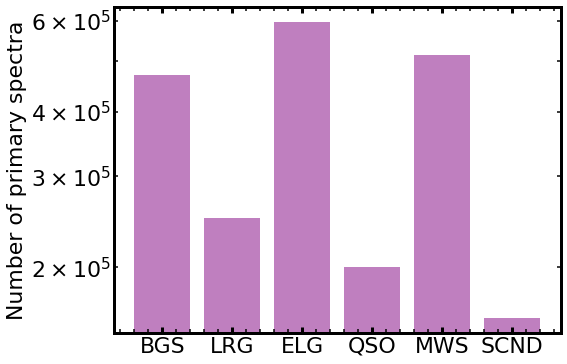

In [17]:
# Let us look at the numbers visually - 

plt.figure(figsize = (8,6))

targets = ['BGS', 'LRG', 'ELG', 'QSO', 'MWS', 'SCND']
numbers = [n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd]

plt.bar(targets, numbers, color = 'purple', alpha = 0.5)
plt.ylabel('Number of primary spectra')
plt.yscale('log')

Text(0.5, 0, 'Redshift')

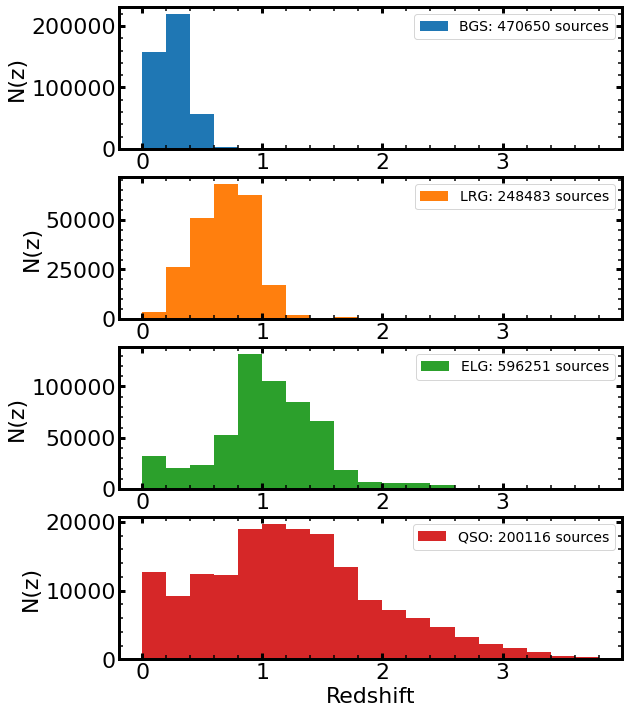

In [18]:
## Now let us look at the distribution of redshifts -
## List of masks of different targeting classes
tgts = [is_bgs, is_lrg, is_elg, is_qso]

## List of the targeting class names
names = ['BGS', 'LRG', 'ELG', 'QSO']

## List of number of targets of each targeting class
nums = [n_bgs, n_lrg, n_elg, n_qso]

fig, axs = plt.subplots(4, 1, figsize = (9, 12))
bins = np.arange(0, 4, 0.2)

## Looping over the targeting classes to plot the redshift distribution of the targets
for ii in range(len(tgts)):
    axs[ii].hist(zpix_cat['z'][tgts[ii]], color = f'C{ii}', bins = bins, label = f'{names[ii]}: {nums[ii]} sources')
    axs[ii].set_ylabel("N(z)")
    axs[ii].legend(fontsize = 14)
axs[3].set_xlabel("Redshift")

### Other masks

The `SV*_DESI_TARGET` columns consists of the uppermost level targeting information in DESI. However, there are sub-classes of targets. <br/>
For example, BGS have different target masks depending on the selection criterion. Each of the different secondary target proposals have their own masks. They can be selected in a similar way as above, but with the respective columns (like `SV1_BGS_TARGET` or `SV1_SCND_TARGET` in the `target` table. More information about Bitmasks in DESI is available [here](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html).

<a class="anchor" id="hpx_sel"></a>
## Selecting Sources in a Region of the Sky

Here, we show how to query unique targets from DESI EDR in a given region of the sky. 

We also select and overplot the `Milky Way Survey` targets in this region.

In [19]:
query = """
SELECT zp.targetid, zp.survey, zp.program, zp.healpix,  
       zp.z, zp.zwarn, zp.coadd_fiberstatus, zp.spectype, 
       zp.mean_fiber_ra, zp.mean_fiber_dec, zp.zcat_nspec, zp.desi_target,
       zp.sv1_desi_target, zp.sv2_desi_target, zp.sv3_desi_target
FROM desi_edr.zpix AS zp
WHERE (zp.mean_fiber_ra > 184) AND (zp.mean_fiber_ra < 184.5) 
AND (zp.mean_fiber_dec > 0.5) AND (zp.mean_fiber_dec < 1.0)
AND (zp.zcat_primary = 't')
""" 

## ZCAT_PRIMARY == 't' for primary spectra

In [20]:
print(query)


SELECT zp.targetid, zp.survey, zp.program, zp.healpix,  
       zp.z, zp.zwarn, zp.coadd_fiberstatus, zp.spectype, 
       zp.mean_fiber_ra, zp.mean_fiber_dec, zp.zcat_nspec, zp.desi_target,
       zp.sv1_desi_target, zp.sv2_desi_target, zp.sv3_desi_target
FROM desi_edr.zpix AS zp
WHERE (zp.mean_fiber_ra > 184) AND (zp.mean_fiber_ra < 184.5) 
AND (zp.mean_fiber_dec > 0.5) AND (zp.mean_fiber_dec < 1.0)
AND (zp.zcat_primary = 't')



In [21]:
tsel = qc.query(sql = query, fmt = 'table')

In [22]:
## MWS bit - 61
is_mws = check_bits(tsel, 61)

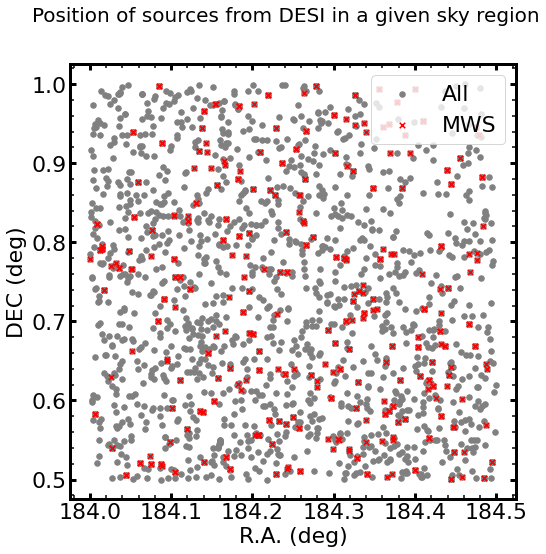

In [23]:
plt.figure(figsize = (8, 8))

plt.suptitle('Position of sources from DESI in a given sky region', fontsize = 20)
plt.scatter(tsel['mean_fiber_ra'], tsel['mean_fiber_dec'], color = 'grey', s = 30, label = 'All')
plt.scatter(tsel['mean_fiber_ra'][is_mws], tsel['mean_fiber_dec'][is_mws], color = 'r', s = 30, marker = 'x', label = 'MWS')
plt.xlabel('R.A. (deg)')
plt.ylabel('DEC (deg)')
plt.legend()

<a class="anchor" id="spectra_access"></a>
# Accessing and Plotting the Spectra of a Given Object

Finally, we show how to access all the available healpix-coadded spectra of a given object. We also show how to select the "best" spectrum. <br/>
We use SPARCL, which is a fast spectral access service at Data Lab. <br/>
Detailed ways to using SPARCL are available in this [notebook](https://github.com/astro-datalab/notebooks-latest/blob/master/04_HowTos/SPARCL/How_to_use_SPARCL.ipynb).

In [24]:
## Select STAR with nspec > 3
jj = (zpix_cat['zcat_nspec'] > 3) & (zpix_cat['spectype'] == 'STAR')
tsel = zpix_cat[jj]

In [25]:
len(tsel)

308

In [26]:
## Randomly select an object
## You can test any object with ii = 0 to 307

ii = 50
targetid = int(tsel['targetid'].data[ii])   ## SPARCL accepts only python integers in specid_list

In [27]:
## Retrieve Spectra

inc = ['specid', 'redshift', 'flux', 'wavelength', 'spectype', 'specprimary', 'survey', 'program', 'targetid', 'coadd_fiberstatus']
res = client.retrieve_by_specid(specid_list = [targetid],
                                include = inc,
                                dataset_list = ['DESI-EDR'])

In [28]:
## Checking that all the different spectra are retrieved

print ('Number of coadded spectra: ', tsel['zcat_nspec'].data[ii])
print ('Number of retrieved records: ', len(res.records))

Number of coadded spectra:  4
Number of retrieved records:  4


In [29]:
res

Retrieved Results: 4 records

In [30]:
records = res.records

## Select the primary spectrum
spec_primary = np.array([records[jj].specprimary for jj in range(len(records))])

primary_ii = np.where(spec_primary == True)[0][0]

In [31]:
lam_primary = records[primary_ii].wavelength
flam_primary = records[primary_ii].flux

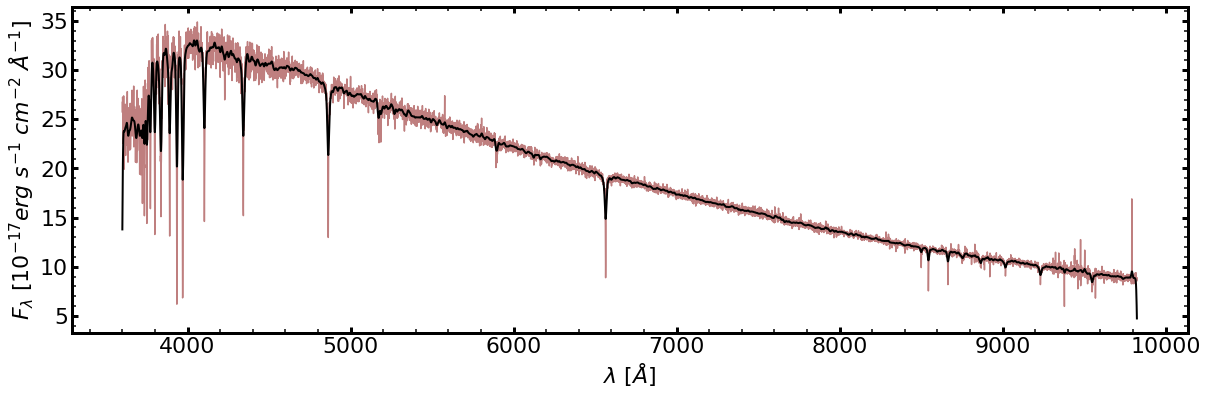

In [32]:
## Plotting this spectrum -

plt.figure(figsize = (20, 6))
## Plot the spectrum from each arm (B,R,Z) in blue, green, red

plt.plot(lam_primary, flam_primary, color = 'maroon', alpha = 0.5)
## Over-plotting smoothed spectrum in black 
plt.plot(lam_primary, convolve(flam_primary, Gaussian1DKernel(5)), color = 'k', lw = 2.0)
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.show()

Let us now plot all the available spectra for this object. 

In each case, the `survey`, `program` and the `primary` flag is mentioned with the spectra.

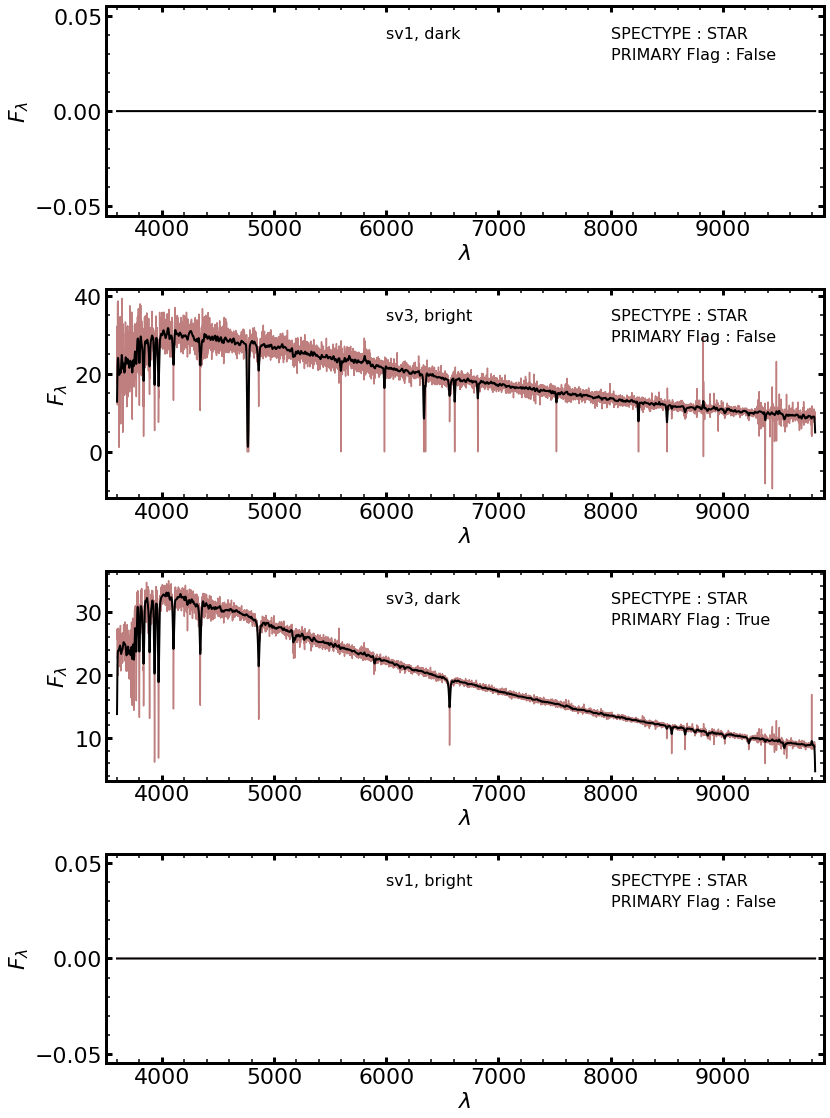

In [33]:
# Number of spectra 
n = len(records)

fig, ax = plt.subplots(n, 1, figsize = (12,(4*n)))

for jj in range(n):
    survey = records[jj].survey
    program = records[jj].program
    spectype = records[jj].spectype
    primary_flag = records[jj].specprimary

    lam = records[jj].wavelength
    flam = records[jj].flux
    
    # Plot the combined spectrum in maroon
    ax[jj].plot(lam, flam, color = 'maroon', alpha = 0.5)
    # Over-plotting smoothed spectra 
    ax[jj].plot(lam, convolve(flam, Gaussian1DKernel(5)), color = 'k', lw = 2.0)
    ax[jj].set(xlim = [3500, 9900], xlabel = '$\lambda$', ylabel = '$F_{\lambda}$')
    trans = ax[jj].get_xaxis_transform()
    ax[jj].annotate(f'{survey}, {program}', xy = (6000, 0.85), xycoords = trans, fontsize = 16)
    ax[jj].annotate(f'SPECTYPE : {spectype}', xy = (8000, 0.85), xycoords = trans, fontsize = 16)
    ax[jj].annotate(f'PRIMARY Flag : {primary_flag}', xy = (8000, 0.75), xycoords = trans, fontsize = 16)
    
plt.tight_layout()

From the above plot, we can see that the spectrum with PRIMARY Flag = True is the one with the highest signal-to-noise ratio. The other available spectrum is a bit noisy, compared to the "best" spectrum.
We see that the two SV1 records of this object show no spectra. Let us check their fiber status below.

In [34]:
print ('Coadd Fiberstatus of the SV1 Dark observation: ', records[0].coadd_fiberstatus)
print ('Coadd Fiberstatus of the SV1 Bright observation: ', records[3].coadd_fiberstatus)

Coadd Fiberstatus of the SV1 Dark observation:  512
Coadd Fiberstatus of the SV1 Bright observation:  512


The `coadd_fiberstatus` of the observations contains [information about the fiber conditions](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html#spectroscopic-reduction-masks) during the spectra observations. `coadd_fiberstatus` = 512 indicates bad fiber conditions, resulting in no spectra (flux = 0 and ivar = 0). This shows the importance of accessing the "best" spectra for scientific analysis.

<a class="anchor" id="ref"></a>
# References

* DESI EDR Documentation: https://data.desi.lbl.gov/doc/
* DESI EDR at Astro Data Lab: https://datalab.noirlab.edu/desi/
* Information about SPARCL: https://astrosparcl.datalab.noirlab.edu/sparc/
* Datamodel information: https://desidatamodel.readthedocs.io/en/latest/
    * [tiles-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/tiles-SPECPROD.html)
    * [exposures-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/exposures-SPECPROD.html)
    * [Redshift catalogs](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/index.html)
    * [zall-pix-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-pix-SPECPROD.html)
    * [zall-tilecumulative-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-tilecumulative-SPECPROD.html)
    * [zpix-SURVEY-PROGRAM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html)
    * [ztile-SURVEY-PROGRAM-GROUPTYPE.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html)
    * [coadd-SURVEY-PROGRAM-PIXNUM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/coadd-SURVEY-PROGRAM-PIXNUM.html)
    * [redshift-SURVEY-PROGRAM-PIXNUM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/redrock-SURVEY-PROGRAM-PIXNUM.html)
* Information about DESI bitmasks: https://desidatamodel.readthedocs.io/en/latest/bitmasks.html
* Information about DESI target bitmasks: https://desidatamodel.readthedocs.io/en/latest/bitmasks.html#target-masks
* DESI Target Selection pipeline paper: [Myers et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165...50M/abstract)
* Introduction to SPARCL notebook: https://github.com/astro-datalab/notebooks-latest/blob/master/04_HowTos/SPARCL/How_to_use_SPARCL.ipynb

# Acknowledgments

* DESI Data License and Acknowledgments: https://data.desi.lbl.gov/doc/acknowledgements/
* Astro Data Lab Acknowledgments: https://datalab.noirlab.edu/acknowledgements.php
* SPARCL Acknowledgments: https://astrosparcl.datalab.noirlab.edu/sparc/acknowledgments

---